2024-10-22 00:38:33.792466: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/assert_equal_35/Assert/AssertGuard/branch_executed/_639
W0000 00:00:1729557514.140870     314 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 200 } dim { size: 304 } dim { size: 256 } } } inputs { dtype: DT_FLOAT shape { dim { size: -47 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -47 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 49 } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100 80GB PCIe MIG 3g.40gb" frequency: 1410 num_cores: 42 environment { key: "architecture" v

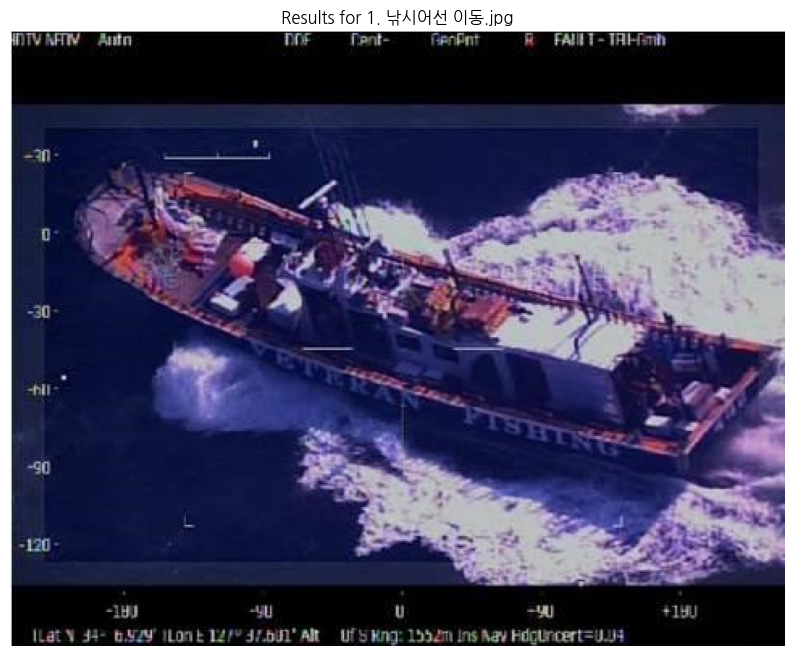

In [23]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import cv2
import matplotlib.pyplot as plt

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)  # GPU 메모리를 필요할 때만 할당
    except RuntimeError as e:
        print(e)

# Faster R-CNN 모델 로드
model = hub.load("https://www.kaggle.com/models/rishitdagli/faster-rcnn-cppe5/TensorFlow2/faster-rcnn-cppe5/1")
detector = model.signatures['serving_default']  # 모델의 기본 시그니처 가져오기

# 이미지 디렉토리 경로 설정 (테스트 이미지들이 있는 폴더)
image_dir = '/home/elicer/FIshing_vessel/imgdata'  # 이 부분을 실제 이미지 폴더 경로로 수정하세요

# 원하는 이미지 파일 이름 설정 (여기서 원하는 파일 이름을 지정하세요)
target_filename = '1. 낚시어선 이동.jpg'  # 원하는 이미지 파일 이름

# 이미지 파일들 반복 처리
for filename in os.listdir(image_dir):
    if filename == target_filename:  # 지정한 파일만 처리
        image_path = os.path.join(image_dir, filename)

        # 이미지 불러오기 및 전처리
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # RGB로 변환
        image_resized = cv2.resize(image_rgb, (1216, 800))/255   # 모델 입력 크기에 맞게 조정 (예: 1216x800, 채널 위치 수정)

        # 모델 입력을 위한 텐서로 변환 (채널 수가 3이어야 함)
        if image_resized.shape[-1] != 3:
            raise ValueError(f"Input image must have 3 channels, but got {image_resized.shape[-1]} channels.")
        
        image_tensor = tf.convert_to_tensor(image_resized, dtype=tf.float32)
        image_tensor = tf.transpose(image_tensor, [2, 0, 1])  # 채널을 맨 앞으로 이동
        image_tensor = tf.expand_dims(image_tensor, axis=0)  # 배치 차원 추가 (배치 크기 1)

        # 예측 수행 (입력을 텐서로 바로 전달)
        results = detector(input=image_tensor)

        # 예측 결과 추출
        result = {key: value.numpy() for key, value in results.items()}

        # 박스, 클래스, 점수 추출 및 시각화
        boxes = result["dets"][0][:, :4]  # [ymin, xmin, ymax, xmax]
        classes = result["labels"][0].astype(np.int32)
        scores = result["dets"][0][:, 4]  # 각 박스의 신뢰도 점수

        height, width, _ = image_rgb.shape
        for i in range(len(classes)):
            if scores[i] > 0.1:  # 신뢰도 50% 이상만 표시
                ymin, xmin, ymax, xmax = boxes[i]
                start_point = (int(xmin * width), int(ymin * height))
                end_point = (int(xmax * width), int(ymax * height))
                color = (0, 255, 0)  # 초록색
                thickness = 2
                cv2.rectangle(image_rgb, start_point, end_point, color, thickness)

                # 클래스 정보 표시
                label = f"Class {classes[i]}: {scores[i]:.2f}"
                cv2.putText(image_rgb, label, (start_point[0], start_point[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # 결과 이미지 시각화
        plt.figure(figsize=(10, 10))
        plt.imshow(image_rgb)
        plt.title(f"Results for {filename}")
        plt.axis('off')
        plt.show()


2024-10-22 06:11:20.089264: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/assert_equal_33/Assert/AssertGuard/branch_executed/_629
W0000 00:00:1729577480.601439   12983 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 200 } dim { size: 304 } dim { size: 256 } } } inputs { dtype: DT_FLOAT shape { dim { size: -47 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -47 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 49 } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100 80GB PCIe MIG 3g.40gb" frequency: 1410 num_cores: 42 environment { key: "architecture" v

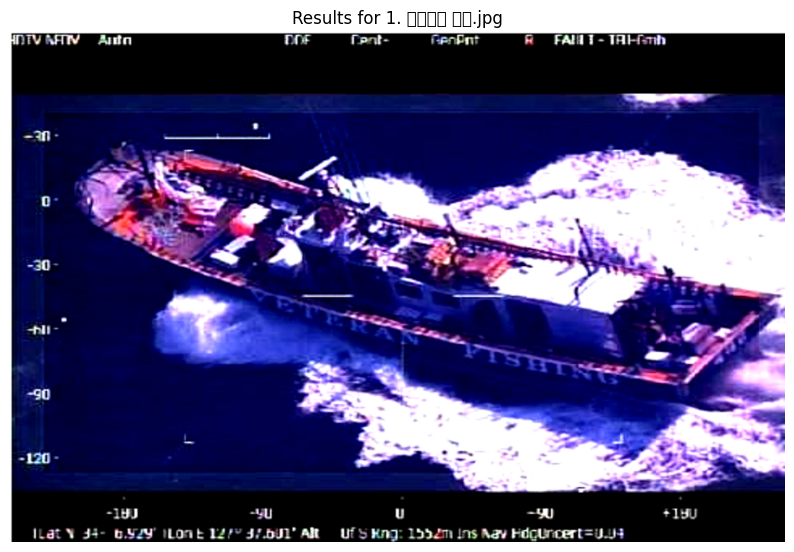

In [5]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance, ImageDraw

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)  # GPU 메모리를 필요할 때만 할당
    except RuntimeError as e:
        print(e)

# Faster R-CNN 모델 로드
model = hub.load("https://www.kaggle.com/models/rishitdagli/faster-rcnn-cppe5/TensorFlow2/faster-rcnn-cppe5/1")
detector = model.signatures['serving_default']  # 모델의 기본 시그니처 가져오기

# 이미지 디렉토리 경로 설정 (테스트 이미지들이 있는 폴더)
image_dir = '/home/elicer/FIshing_vessel/imgdata'  # 이 부분을 실제 이미지 폴더 경로로 수정하세요

# 원하는 이미지 파일 이름 설정 (여기서 원하는 파일 이름을 지정하세요)
target_filename = '1. 낚시어선 이동.jpg'  # 원하는 이미지 파일 이름

# 이미지 파일들 반복 처리
for filename in os.listdir(image_dir):
    if filename == target_filename:  # 지정한 파일만 처리
        image_path = os.path.join(image_dir, filename)

        # 이미지 불러오기 및 전처리
        image = Image.open(image_path).convert('RGB')  # RGB로 변환

        # 히스토그램 평활화 적용 (대비 향상)
        enhancer = ImageEnhance.Contrast(image)
        image = enhancer.enhance(2.0)  # 대비 조절 (값을 조정하여 대비를 높임)

        image_resized = image.resize((1216, 800))  # 모델 입력 크기에 맞게 조정
        image_array = np.array(image_resized) / 255.0  # 정규화

        # 모델 입력을 위한 텐서로 변환 (채널 수가 3이어야 함)
        if image_array.shape[-1] != 3:
            raise ValueError(f"Input image must have 3 channels, but got {image_array.shape[-1]} channels.")
        
        image_tensor = tf.convert_to_tensor(image_array, dtype=tf.float32)
        image_tensor = tf.transpose(image_tensor, [2, 0, 1])  # 채널을 맨 앞으로 이동
        image_tensor = tf.expand_dims(image_tensor, axis=0)  # 배치 차원 추가 (배치 크기 1)

        # 예측 수행 (입력을 텐서로 바로 전달)
        results = detector(input=image_tensor)

        # 예측 결과 추출
        result = {key: value.numpy() for key, value in results.items()}

        # 박스, 클래스, 점수 추출 및 시각화
        boxes = result["dets"][0][:, :4]  # [ymin, xmin, ymax, xmax]
        classes = result["labels"][0].astype(np.int32)
        scores = result["dets"][0][:, 4]  # 각 박스의 신뢰도 점수

        height, width = image.size
        image_draw = Image.fromarray((image_array * 255).astype(np.uint8))
        for i in range(len(classes)):
            if scores[i] > 0.1:  # 신뢰도 50% 이상만 표시
                ymin, xmin, ymax, xmax = boxes[i]
                start_point = (int(xmin * width), int(ymin * height))
                end_point = (int(xmax * width), int(ymax * height))
                
                # 박스 그리기
                draw = ImageDraw.Draw(image_draw)
                draw.rectangle([start_point, end_point], outline=(0, 255, 0), width=2)
                
                # 클래스 정보 표시
                label = f"Class {classes[i]}: {scores[i]:.2f}"
                draw.text((start_point[0], start_point[1] - 10), label, fill=(0, 255, 0))

        # 결과 이미지 시각화
        plt.figure(figsize=(10, 10))
        plt.imshow(image_draw)
        plt.title(f"Results for {filename}")
        plt.axis('off')
        plt.show()
